In [117]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import accuracy_score
import mlflow
import mlflow.pytorch
from torchvision.transforms import v2

In [118]:
# Dirs
cwd= os.getcwd()
data_dir= os.path.join(cwd, "data/")
artifacts_dir= os.path.join(cwd, "artifacts/")

In [119]:
torch.manual_seed(42)
BATCH_SIZE= 64
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset= datasets.CIFAR100(root= data_dir, train= True, download= True, transform= transform)
val_dataset= datasets.CIFAR100(root= data_dir, train= False, download= False, transform= transform)

train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
val_loader= DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle= False)


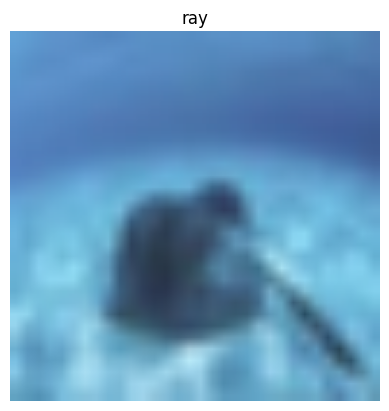

In [120]:
class_names= train_dataset.classes
batch= next(iter(train_loader))
random_index= random.randint(0, BATCH_SIZE)

def visualize_image(input, class_names, title= None):
    input= input.numpy().transpose((1,2,0))
    mean= np.array([0.485, 0.456, 0.406])
    std= np.array([0.229, 0.224, 0.225])
    input= std * input + mean
    input= np.clip(input, 0, 1)
    plt.axis('off')
    plt.imshow(input)
    if title is not None:
        plt.title(class_names[sample_label.item()])
    plt.pause(0.001)
# Visualize random image in batch
sample_image= batch[0][random_index]
sample_label= batch[1][random_index]
visualize_image(sample_image, class_names, sample_label)

In [121]:
full_ft_model= models.resnet18(pretrained= True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [122]:
num_classes= len(class_names)
num_features= full_ft_model.fc.in_features
full_ft_model.fc= nn.Linear(num_features, num_classes)
# Unfreeze all layers
for param in full_ft_model.parameters():
    param.requires_grad= True

In [123]:
loss_fn= nn.CrossEntropyLoss()
preds= full_ft_model(batch[0])
class_preds= F.softmax(preds, dim= 1).argmax(dim=-1)
loss_fn(preds, batch[1])
accuracy_score(batch[1], class_preds)

0.015625

In [124]:
def train_model(model,
                train_loader,
                val_loader,
                optimizer,
                scheduler,
                loss_fn,
                device,
                log_fn= None,
                cutmix_mixup= None,
                n_epochs= 15):
    # Global History
    train_loss_history= []
    train_acc_history= []
    val_loss_history= []
    val_acc_history= []

    # Early Stopping
    best_val_accuracy= 0
    min_delta= 0.5
    patience= 3
    epochs_without_improvement= 0

    model.to(device)
    for epoch in range(1, n_epochs + 1):
        # Train
        model.train()
        # Metrics setup
        running_train_loss= 0.0
        all_predictions= []
        all_labels= []

        for batch in train_loader:

            images_batch, labels_batch= batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()

            if cutmix_mixup is not None:
              images_batch, labels_batch= cutmix_mixup(images_batch, labels_batch)
              accuracy_labels= torch.argmax(labels_batch, dim= 1)
            else:
              accuracy_labels= labels_batch

            # Forward
            predictions= model(images_batch)
            loss= loss_fn(predictions, labels_batch)

            # Backward
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm= 3.0) # Clipping grad norms
            optimizer.step()


            # Metrics calculation
            running_train_loss+= loss.item()
            class_preds= F.softmax(predictions, dim= 1).argmax(dim=-1)
            all_predictions.extend(class_preds.cpu().numpy())
            all_labels.extend(accuracy_labels.cpu().numpy())

        avg_train_loss= running_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        train_epoch_accuracy= 100 * accuracy_score(all_labels, all_predictions)
        train_acc_history.append(train_epoch_accuracy)

        # Call logging function if it was provided
        if log_fn is not None:
          log_fn({"train_loss": avg_train_loss, "epoch": epoch})
          log_fn({"train_accuracy": train_epoch_accuracy, "epoch": epoch})

        model.eval()
        running_val_loss= 0.0
        all_predictions= []
        all_labels= []

        with torch.no_grad():
            for batch in val_loader:
                images_batch, labels_batch= batch[0].to(device), batch[1].to(device)

                predictions= model(images_batch)
                loss= loss_fn(predictions, labels_batch)
                running_val_loss+= loss.item()

                class_preds= F.softmax(predictions, dim= 1).argmax(dim= -1)
                all_predictions.extend(class_preds.cpu().numpy())
                all_labels.extend(labels_batch.cpu().numpy())

            avg_val_loss= running_val_loss / len(val_loader)
            val_loss_history.append(avg_val_loss)

            val_epoch_accuracy= 100 * accuracy_score(all_labels, all_predictions)
            val_acc_history.append(val_epoch_accuracy)
            scheduler.step()

        if log_fn is not None:
          log_fn({"val_loss": avg_val_loss, "epoch": epoch})
          log_fn({"val_accuracy": val_epoch_accuracy, "epoch": epoch})

        print(f"Epoch: {epoch}")
        print("-"*15)
        print(f"Train Loss: {avg_train_loss:.3f} | Train Accuracy: {train_epoch_accuracy:.2f}%")
        print(f"Val Loss: {avg_val_loss:.3f} | Val Accuracy: {val_epoch_accuracy:.2f}%")

        # Check for early stopping
        if best_val_accuracy + min_delta < val_epoch_accuracy:
            best_val_accuracy= val_epoch_accuracy
            epochs_without_improvement= 0
        else:
            epochs_without_improvement+= 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after epoch {epoch}")
            break
    training_epochs= list(range(1, epoch + 1))

    return {
        "train_loss_history": train_loss_history,
        "train_acc_history": train_acc_history,
        "val_loss_history": val_loss_history,
        "val_acc_history": val_acc_history,
        "epochs": training_epochs
    }

In [125]:
cutmix= v2.CutMix(num_classes= num_classes)
mixup= v2.MixUp(num_classes= num_classes)
cutmix_or_mixup= v2.RandomChoice([cutmix, mixup])

In [126]:
torch.manual_seed(42)
LEARNING_RATE= 0.01
NUM_EPOCHS= 30
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Separate parameters feature extraction layers / fc layer
feature_ext_params= []
fc_params= []
for name, param in full_ft_model.named_parameters():
    if 'fc' in name:
        fc_params.append(param)
    else:
        feature_ext_params.append(param)
with mlflow.start_run(run_name= "resnet18_ls_cm_mu_imgnetnorms"):
  loss_fn= nn.CrossEntropyLoss(label_smoothing= 0.1)
  optimizer= torch.optim.SGD([
      # Different LR for feat_ext_params and fc_params
      {'params': feature_ext_params, 'lr': LEARNING_RATE / 10, 'weight_decay': 1e-4},
      {'params': fc_params, 'lr': LEARNING_RATE, 'weight_decay': 1e-4}
  ], momentum= 0.9)
  def mlflow_logger(metrics_dict):
    mlflow.log_metrics(metrics_dict, step= metrics_dict["epoch"])

  mlflow.log_params({
            "learning_rate": LEARNING_RATE,
            "batch_size": BATCH_SIZE,
            "optimizer": type(optimizer).__name__
        })


  scheduler= torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)
  full_ft_history= train_model(full_ft_model,
                               train_loader,
                               val_loader,
                               optimizer,
                               scheduler,
                               loss_fn,
                               device,
                               mlflow_logger,
                               cutmix_or_mixup,
                               NUM_EPOCHS)
  mlflow.pytorch.log_model(full_ft_model, "resnet18_ls_cm_mu_imgnetnorms")

Epoch: 1
---------------
Train Loss: 3.522 | Train Accuracy: 32.60%
Val Loss: 1.955 | Val Accuracy: 64.88%
Epoch: 2
---------------
Train Loss: 2.912 | Train Accuracy: 53.04%
Val Loss: 1.740 | Val Accuracy: 72.10%
Epoch: 3
---------------
Train Loss: 2.840 | Train Accuracy: 55.72%
Val Loss: 1.668 | Val Accuracy: 74.19%
Epoch: 4
---------------
Train Loss: 2.759 | Train Accuracy: 58.84%
Val Loss: 1.631 | Val Accuracy: 75.40%
Epoch: 5
---------------
Train Loss: 2.735 | Train Accuracy: 59.94%
Val Loss: 1.587 | Val Accuracy: 76.91%
Epoch: 6
---------------
Train Loss: 2.705 | Train Accuracy: 61.46%
Val Loss: 1.576 | Val Accuracy: 77.15%
Epoch: 7
---------------
Train Loss: 2.678 | Train Accuracy: 61.99%
Val Loss: 1.565 | Val Accuracy: 77.56%
Epoch: 8
---------------
Train Loss: 2.643 | Train Accuracy: 63.72%
Val Loss: 1.541 | Val Accuracy: 78.29%
Epoch: 9
---------------
Train Loss: 2.633 | Train Accuracy: 63.83%
Val Loss: 1.534 | Val Accuracy: 78.36%
Epoch: 10
---------------
Train Loss:

2025/09/20 16:04:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/20 16:04:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 17
---------------
Train Loss: 2.495 | Train Accuracy: 68.46%
Val Loss: 1.487 | Val Accuracy: 80.26%
Early stopping triggered after epoch 17


2025/09/20 16:04:22 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.23.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/20 16:04:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [127]:
import shutil
from google.colab import files
shutil.make_archive('mlruns', 'zip', '/content/mlruners')
files.download('mlruns.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>